In [3]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from urllib.request import urlopen


# Custom data loader

In [4]:
class CustomFashionMNIST(Dataset):
    def __init__(self, labels_url, images_url):
        # read in our images raw data from the hosting URL
        with urlopen(labels_url) as lbpath:
            with gzip.GzipFile(fileobj=lbpath) as lbfile:
                self.labels = np.frombuffer(
                    lbfile.read(),
                    dtype=np.uint8,
                    offset=8)
        with urlopen(images_url) as imgpath:
            with gzip.GzipFile(fileobj=imgpath) as imgfile:
                self.images = (np.frombuffer(
                    imgfile.read(),
                    dtype=np.uint8,
                    offset=16)
                # reshape so that each record/image is a 28x28 matrix (each image has 28 pixels)
                .reshape(len(self.labels), 28, 28))

    # return the length of the complete data set
    #   to be used in internal calculations for pytorch
    def __len__(self):
        return self.labels.shape[0]

    # retrieve a single record based on index position `index`
    def __getitem__(self, index):
        # extract the image and label
        image = self.images[index]  # will get the 28x28 image at the given index
        label = self.labels[index]  # will get the label corresponding to the image

        # Specify dtype to align with default dtype used by weight matrices
        image = torch.tensor(image, dtype=torch.float32)

        # return the image and its corresponding label
        return image, label

In [5]:
train_images_url = 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz'
train_labels_url = 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz'
test_images_url = 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz'
test_labels_url = 'https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz'

# Load our data into memory
train_data = CustomFashionMNIST(train_labels_url, train_images_url)
test_data = CustomFashionMNIST(test_labels_url, test_images_url)

# Create data feed pipelines for modeling
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


This image is labeled a 9


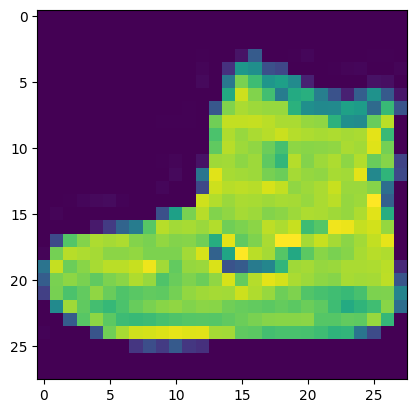

In [6]:
idx=0
print(f"This image is labeled a {train_data.__getitem__(idx)[1]}")
plt.imshow(train_data.__getitem__(idx)[0].reshape(28, 28))

# Build Neural Net

In [7]:
class MyNeuralNet(nn.Module):
    def __init__(self):
      # We define the components of our model here
      super(MyNeuralNet, self).__init__()
      # Function to flatten our image
      self.flatten = nn.Flatten()
      # Create the sequence of our network
      self.linear_relu_model = nn.Sequential(
            # Add a linear output layer w/ 10 perceptrons
            nn.LazyLinear(10),
        )
      
    def forward(self, x):
      # We construct the sequencing of our model here
      x = self.flatten(x)
      # Pass flattened images through our sequence
      output = self.linear_relu_model(x)

      # Return the evaluations of our ten 
      #   classes as a 10-dimensional vector
      return output

# Create an instance of our model
model = MyNeuralNet()

# Prepare to train the model

In [8]:
# Define some training parameters
learning_rate = 1e-2
batch_size = 64
epochs = 20 

# Define our loss function
#   This one works for multiclass problems
loss_fn = nn.CrossEntropyLoss()

In [9]:
# Build our optimizer with the parameters from
#   the model we defined, and the learning rate
#   that we picked
optimizer = torch.optim.SGD(model.parameters(),
     lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    # important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Loop over batches via the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation and looking for improved gradients
        loss.backward()
        optimizer.step()
        # Zeroing out the gradient (otherwise they are summed)
        #   in preparation for next round
        optimizer.zero_grad()

        # Print progress update every few loops
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Prepare to test

In [11]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode
    # important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures
    # that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations
    # and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Printing some output after a testing round
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
# Need to repeat the training process for each epoch.
#   In each epoch, the model will eventually see EVERY
#   observations in the data
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 69.0%, Avg loss: 1787.399737 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 73.0%, Avg loss: 1391.897253 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 2281.276350 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 69.5%, Avg loss: 2592.514950 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 75.1%, Avg loss: 1327.762304 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 68.2%, Avg loss: 2185.309097 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 74.6%, Avg loss: 1293.735076 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 68.5%, Avg loss: 2173.924466 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 68.9%, Avg loss: 2640.198149 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 72.6%, Avg loss: 1657.243009 

Epoch 11
-------------------------------
Test Err

# Store weights

In [13]:
# Save our model for later, so we can train more or make predictions
EPOCH = epochs
# We use the .pt file extension by convention for saving
#    pytorch models
PATH = "model.pt"

# The save function creates a binary storing all our data for us
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)